In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
# from matplotlib.dates import bytespdate2num

## 1 Load the data set

In [6]:
df = pd.read_csv("~/downloads/corona_tested_individuals_ver_00166.csv", header=0, parse_dates = ['test_date']) ## load the date in local
# df_np = np.loadtxt('corona_tested_individuals_ver_00166.csv', delimiter=',', skiprows=1,
#                           usecols= (1,7), unpack=True)
# df = pd.DataFrame(df)
df.columns = ['date','cough','fever','sore_throat','shortness_of_breath','head_ache','corona_result','age','gender','test_indication']
df = df[df["date"] > "2021-03-30"]

## 2 Data Exploration¶

Explanation of the data:
https://data.gov.il/dataset/covid-19/resource/0ac4cffc-3746-473a-8d4a-ab874b8d8d62

Gender: appears from March 22nd 2020

Corona_result: Results of first Covid-19 test, by category:
    a.Positive – carrying Covid-19
    b.Negative – not carrying Covid-19
    c.Other – Not tested, in testing, inconclusive

Age_60_and_above: Indicator of the test taker's age - 60 or over (1) or below 60 (0). Appears from March 17th 2020.

Test_indication: What is the indication for testing? Abroad – arrived from abroad, contact_with_confirmed – contact with a confirmed case, other – other indication or not specified

Symptoms (whether developed before testing):
cough, fever, sore_throat, shortness of breath, headache: 1 – Yes, 0 – No, NULL – Unknown

Obviously, the corona_result is the label class.

Here we have questions on 1) how to handle missing age values before March 22 and age before March 17. 2)null values (drop or replace) 3) the meaningful use of test date data

In [7]:
df.head()

,date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age,gender,test_indication
0,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other
1,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other
2,2021-07-25,1,1,1,0,1,אחר,No,נקבה,Abroad
3,2021-07-25,0,0,0,0,0,שלילי,No,זכר,Other
4,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other


In [8]:
df.shape

(852374, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852374 entries, 0 to 852373
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 852374 non-null  datetime64[ns]
 1   cough                852374 non-null  int64         
 2   fever                852374 non-null  int64         
 3   sore_throat          852374 non-null  int64         
 4   shortness_of_breath  852374 non-null  int64         
 5   head_ache            852374 non-null  int64         
 6   corona_result        852374 non-null  object        
 7   age                  217614 non-null  object        
 8   gender               380625 non-null  object        
 9   test_indication      852374 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 71.5+ MB


In [10]:
df.isnull().sum()

date                        0
cough                       0
fever                       0
sore_throat                 0
shortness_of_breath         0
head_ache                   0
corona_result               0
age                    634760
gender                 471749
test_indication             0
dtype: int64

According to the offical documents, testing for the virus started in February. However,due to privacy concerns:
1. The information is available from 11 March 2020.
2. Ages have been divided to under 60 and 60 and over, and are published from 17 March until 14 April (before 17 March until 14 April age equals NULL)
3. Sex is published from 22 March (before the date, sex was represented as NULL)

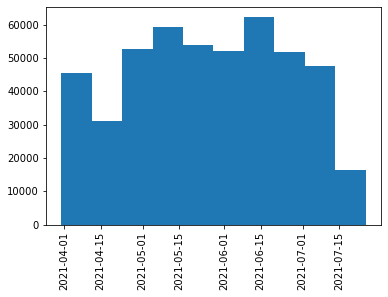

In [12]:
plt.hist(df[df["gender"].isnull()]['date'], bins = 10)
plt.xticks(rotation='vertical');

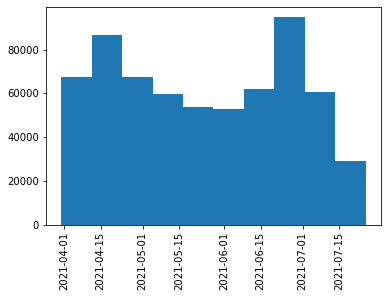

In [13]:
plt.hist(df[df["age"].isnull()]['date'], bins = 10)
plt.xticks(rotation='vertical');

In [14]:
pd.concat([
    df.describe().T,
    df.mad().rename('mad'),
    df.skew().rename('skew'),
    df.kurt().rename('kurt'),
    df.nunique().rename('nunique')
], axis=1).T

,cough,fever,sore_throat,shortness_of_breath,head_ache,date,corona_result,age,gender,test_indication
count,852374.000000,852374.000000,852374.000000,852374.000000,852374.000000,NaN,NaN,NaN,NaN,NaN
mean,0.004448,0.003899,0.001553,0.000318,0.002796,NaN,NaN,NaN,NaN,NaN
std,0.066542,0.062316,0.039381,0.017828,0.052801,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
75%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
max,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
mad,0.008856,0.007767,0.003102,0.000636,0.005576,NaN,NaN,NaN,NaN,NaN
skew,14.894520,15.922066,25.313846,56.056248,18.833309,NaN,NaN,NaN,NaN,NaN


In [15]:
df['corona_result'].unique() 

array(['שלילי', 'אחר', 'חיובי'], dtype=object)

In [16]:
# replacing all the characters in Hebrew by English
df['corona_result'] = df['corona_result'].str.replace('חיובי','Positive')
df['corona_result'] = df['corona_result'].str.replace('אחר','Other')
df['corona_result'] = df['corona_result'].str.replace('שלילי','Negative')

df['gender'] = df['gender'].str.replace('נקבה','Female')
df['gender'] = df['gender'].str.replace('זכר','Male')

## 3 Date Understanding

**BreakDown of Class**

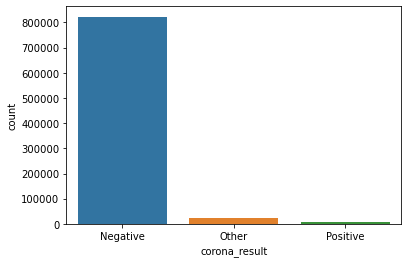

In [18]:
sns.countplot(df['corona_result'],label="Count");

The class lable is highly imbalanced. The proportion of positive instances is less than **5%**. We need to be cautious about this.

**BreakDown of feature distribution**

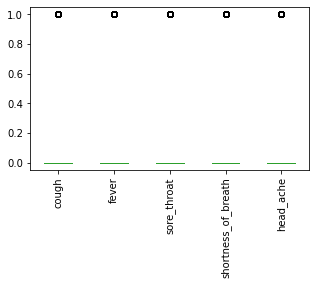

In [20]:
df.plot.box(figsize=(5, 3)) # visualize the feature distribution
plt.xticks(rotation='vertical');
# the value distribution of 5 numeric features are highly skewed with over 75% being 0.

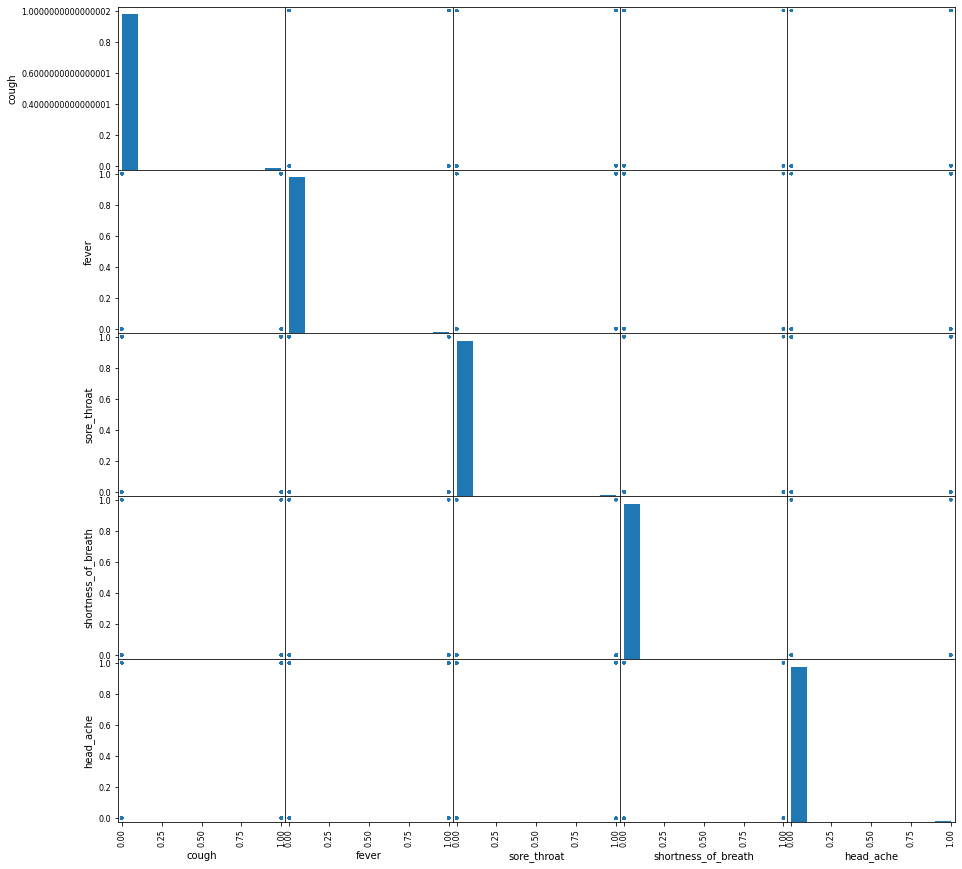

In [57]:
pd.plotting.scatter_matrix(df, alpha = 0.5, figsize = (15, 15)); 

**BreakDown of cough**

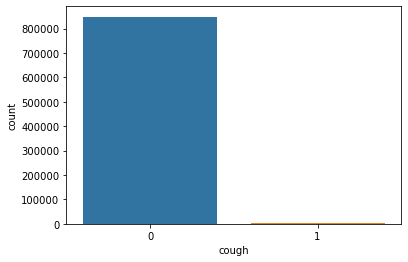

In [21]:
p = sns.countplot(data=df, x="cough")
plt.show()

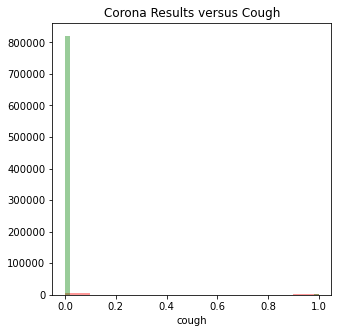

In [22]:
plt.figure(figsize=(5,5))
sns.distplot(df[df['corona_result'] == 'Positive']["cough"], color='red', kde=False) 
# we don't need kernel desity estimate because the feature is discrete.
sns.distplot(df[df['corona_result'] == 'Negative']["cough"], color='green', kde=False)
plt.title('Corona Results versus Cough')
plt.show()

**BreakDown of fever**

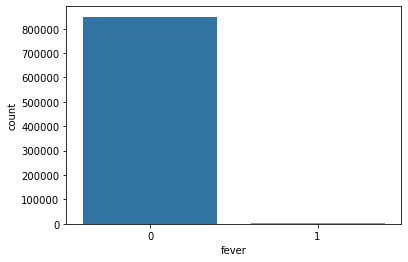

In [24]:
p = sns.countplot(data=df, x="fever")
plt.show()

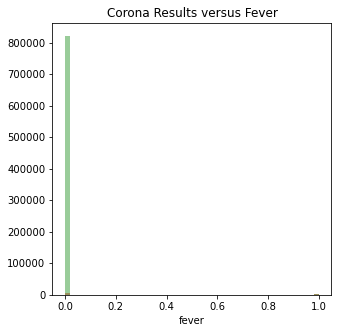

In [25]:
plt.figure(figsize=(5,5))
sns.distplot(df[df['corona_result'] == 'Positive']["fever"], color='red',kde=False) 
sns.distplot(df[df['corona_result'] == 'Negative']["fever"], color='green',kde=False)
plt.title('Corona Results versus Fever')
plt.show()

**BreakDown of sore_throat**

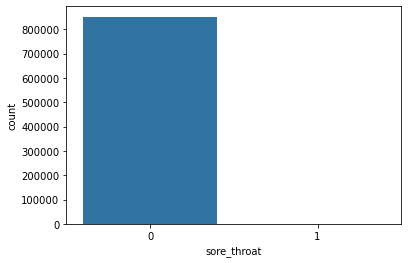

In [26]:
p = sns.countplot(data=df, x="sore_throat")
plt.show()

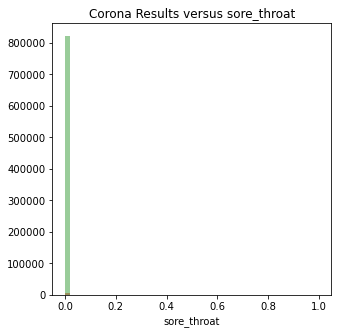

In [27]:
plt.figure(figsize=(5,5))
sns.distplot(df[df['corona_result'] == 'Positive']["sore_throat"], color='red',kde=False) 
sns.distplot(df[df['corona_result'] == 'Negative']["sore_throat"], color='green',kde=False)
plt.title('Corona Results versus sore_throat')
plt.show()

**BreakDown of shortness_of_breath**

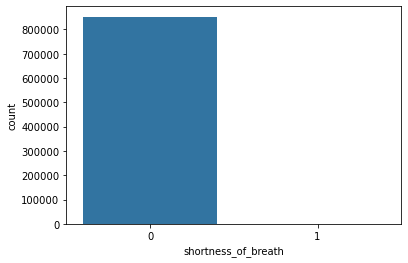

In [28]:
p = sns.countplot(data=df, x="shortness_of_breath")
plt.show()

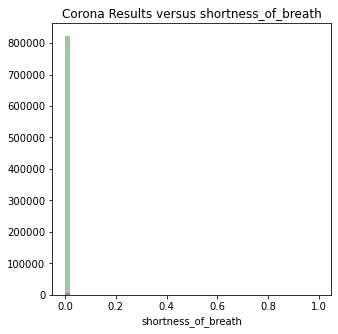

In [29]:
plt.figure(figsize=(5,5))
sns.distplot(df[df['corona_result'] == 'Positive']["shortness_of_breath"], color='red',kde=False) 
sns.distplot(df[df['corona_result'] == 'Negative']["shortness_of_breath"], color='green',kde=False)
plt.title('Corona Results versus shortness_of_breath')
plt.show()

**BreakDown of head_ache**

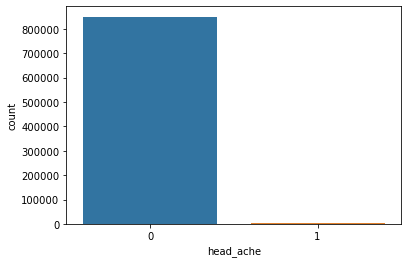

In [30]:
p = sns.countplot(data=df, x="head_ache")
plt.show()

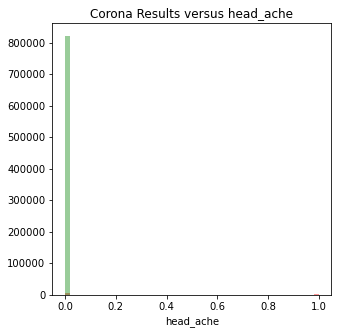

In [31]:
plt.figure(figsize=(5,5))
sns.distplot(df[df['corona_result'] == 'Positive']["head_ache"], color='red',kde=False) 
sns.distplot(df[df['corona_result'] == 'Negative']["head_ache"], color='green',kde=False)
plt.title('Corona Results versus head_ache')
plt.show()

**Corona Result along with time**

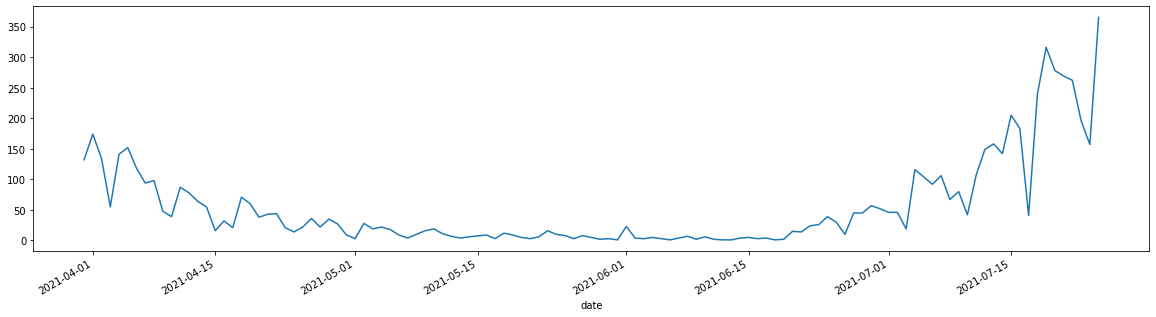

In [32]:
df[df['corona_result'] == "Positive"].groupby('date').size().plot(figsize=(20, 5));

There are two peaks for testing positive results in 2020-10 and 2021-01

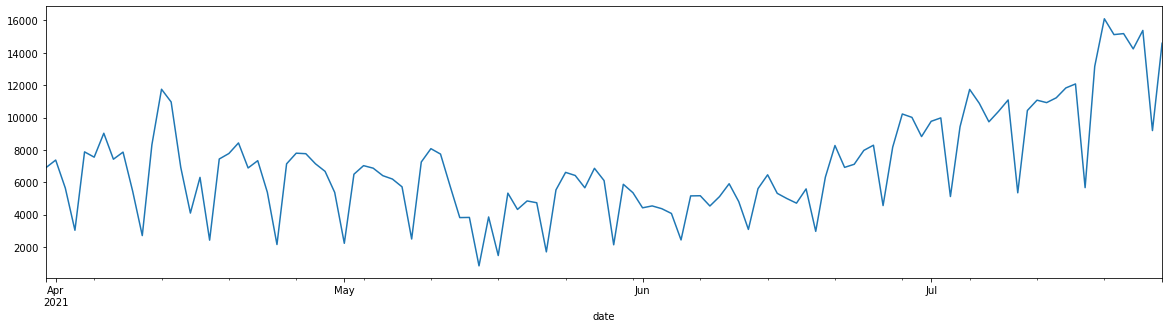

In [33]:
df[df['corona_result'] == "Negative"].groupby('date').size().plot(figsize=(20, 5));

Combining what we have analysed above, the volume of test cases varies month by month.

## 4 Data Preprocessing

**Remove the instances with results of *Others* (not tested, testing)**

In [191]:
df = df[df['corona_result'] != 'Other']
df = df.drop("date", axis = 1)

### Imputation

In [34]:
# How many features have missing values?
n_missing = len(df.columns[df.isnull().any()])
"{} features have missing values.".format(n_missing)

'2 features have missing values.'

In [35]:
keys = ['Total', 'Percent']

null_total = df.isnull().sum().sort_values(ascending=False)
null_percent = (df.isnull().sum() /df.isnull().count())

df_missing = pd.concat([null_total, null_percent], axis=1, keys=keys, sort=False)
df_missing = df_missing.sort_values(by='Percent', ascending=False)
df_missing.head(n_missing)

,Total,Percent
age,634760,0.744697
gender,471749,0.553453


The percentage of the missing values is large. We will test on filled and dropped datasets and see if one improves the accuracy

In [36]:
# replace the missing value
X_filled = df.copy().drop("corona_result", axis = 1)
y_filled = df.copy()["corona_result"]
X_filled_nom = X_filled.select_dtypes(include=[object])
X_filled_num = X_filled.select_dtypes(include=[np.number])

X_filled[X_filled_nom.columns] = X_filled_nom.fillna('Missing')
X_filled.head()

,date,cough,fever,sore_throat,shortness_of_breath,head_ache,age,gender,test_indication
0,2021-07-25,0,0,0,0,0,No,Female,Other
1,2021-07-25,0,0,0,0,0,No,Female,Other
2,2021-07-25,1,1,1,0,1,No,Female,Abroad
3,2021-07-25,0,0,0,0,0,No,Male,Other
4,2021-07-25,0,0,0,0,0,No,Female,Other


In [54]:
# drop the rows with missing value
df_dropped = df.dropna(how = 'any', axis=0)
X_dropped = df_dropped.drop("corona_result", axis = 1)
y_dropped = df_dropped["corona_result"]

In [40]:
n_missing = len(X_dropped.columns[X_dropped.isnull().any()])
"{} features have missing values.".format(n_missing)

'0 features have missing values.'

### Encoding

In [41]:
X_filled_nom_trans = pd.get_dummies(X_filled[X_filled_nom.columns])

In [42]:
X_filled = pd.concat([X_filled_num, X_filled_nom_trans], axis = 1)

In [43]:
X_filled.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_Missing,age_No,age_Yes,gender_Female,gender_Male,gender_Missing,test_indication_Abroad,test_indication_Contact with confirmed,test_indication_Other
0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1,0,0,0,0,0,0,1,0,1,0,0,0,0,1
2,1,1,1,0,1,0,1,0,1,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,1,0,0,0,1
4,0,0,0,0,0,0,1,0,1,0,0,0,0,1


**When dropping the missing value, the two nominal features (gender and age) are all binary feature. Thus we can encode these features as 0 and 1**

In [44]:
# gender and age features are binary so use labelEncoder to be consistent with the syndrome features (binary)
le = LabelEncoder()
le.fit(X_dropped["gender"])
X_dropped["gender"] = le.transform(X_dropped["gender"])
le.fit(X_dropped["age"])
X_dropped["age"] = le.transform(X_dropped["age"])
# X_indication have multi variable so use get dummies instead. OneHotEncoder can't convert df with some string
X_indication = pd.get_dummies(X_dropped["test_indication"])
X_dropped = pd.concat([X_dropped.drop("test_indication", axis=1), X_indication], axis=1)

In [45]:
X_dropped.head()

,date,cough,fever,sore_throat,shortness_of_breath,head_ache,age,gender,Abroad,Contact with confirmed,Other
0,2021-07-25,0,0,0,0,0,0,0,0,0,1
1,2021-07-25,0,0,0,0,0,0,0,0,0,1
2,2021-07-25,1,1,1,0,1,0,0,1,0,0
3,2021-07-25,0,0,0,0,0,0,1,0,0,1
4,2021-07-25,0,0,0,0,0,0,0,0,0,1


**Encoding the class label value**

In [46]:
le.fit(y_dropped)
y_dropped = le.transform(y_dropped)
le.fit(y_filled)
y_filled = le.transform(y_filled)

## Feature selection

In [47]:
# corr for mean
corr1 = X_filled.corr();
corr2 = X_dropped.corr();

**Correlation between features in X_filled (missing values filled)**

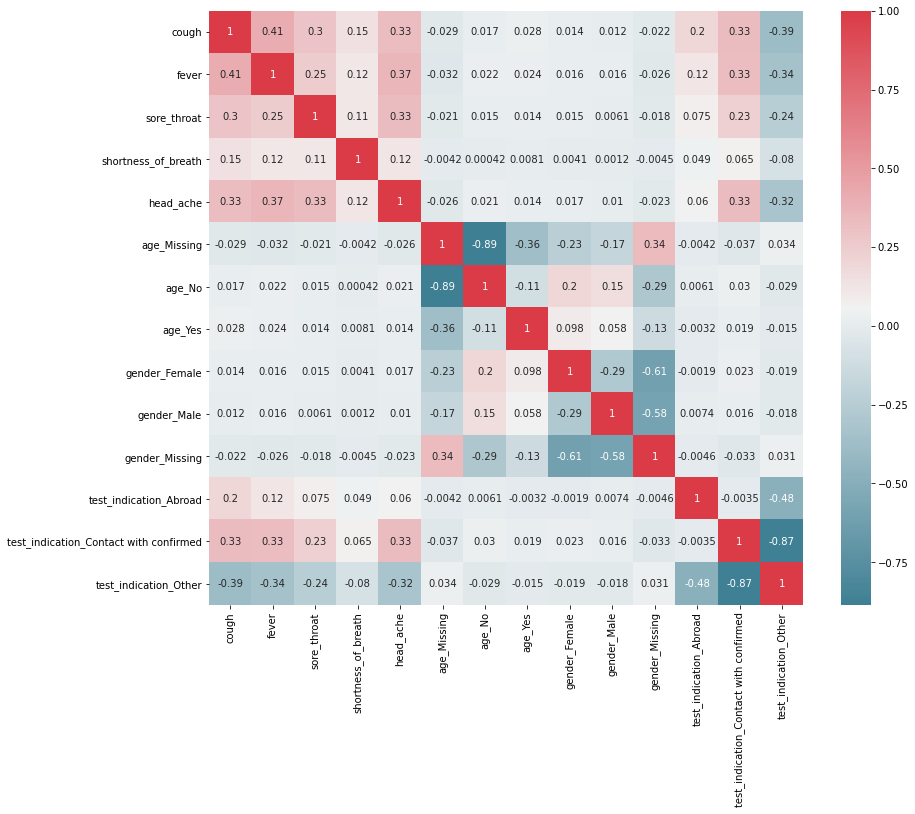

In [48]:
plt.rc("figure", figsize=(15, 15))
grid=sns.heatmap(corr1,annot=True,cbar = True, square = True, cmap=sns.diverging_palette(220, 10, as_cmap=True))
grid.set_xticklabels(corr1.columns,rotation=90)
plt.subplots_adjust(left=0.3,right=1,bottom=0.35,top=0.9)
plt.show()

**Correlation between features in X_dropped (missing values dropped)**

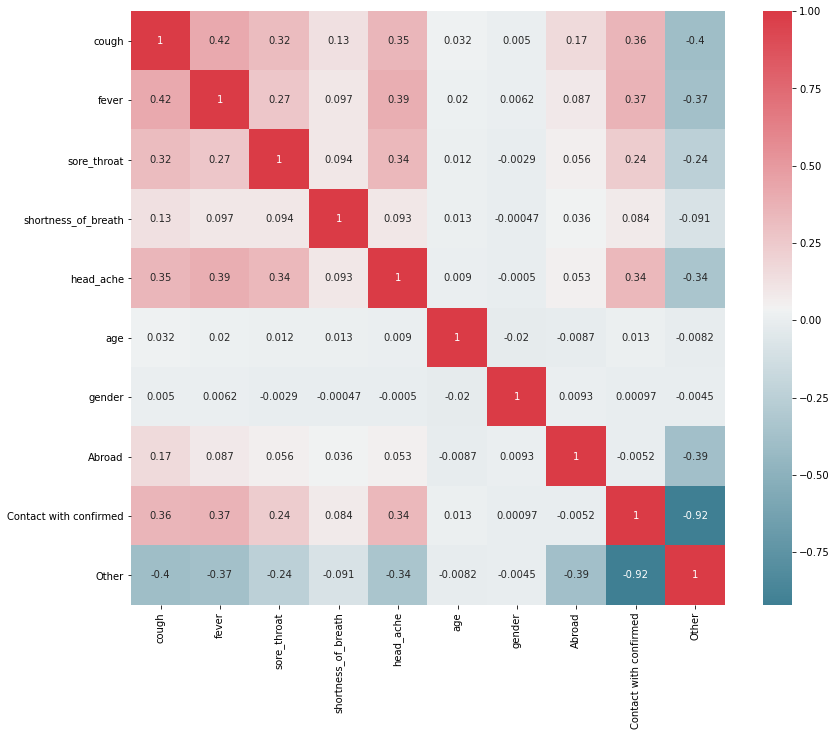

In [49]:
plt.rc("figure", figsize=(15, 15))
grid=sns.heatmap(corr2,annot=True,cbar = True, square = True, cmap=sns.diverging_palette(220, 10, as_cmap=True))
grid.set_xticklabels(corr2.columns,rotation=90)
plt.subplots_adjust(left=0.3,right=1,bottom=0.35,top=0.9)
plt.show()

**Findings: The correlations between any two features are low.**

**Find Mutual Info between each feature and class label (drop date column for now)**

In [51]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
mi = mutual_info_regression(X_filled, y_filled)

In [52]:
df_mi = pd.DataFrame(mi, index=X_filled.columns, columns=['mutual_info'])

In [53]:
df_mi.sort_values("mutual_info", ascending=False)

,mutual_info
test_indication_Other,0.014797
test_indication_Contact with confirmed,0.013979
fever,0.007646
cough,0.007432
head_ache,0.006393
age_Missing,0.004108
age_No,0.003588
sore_throat,0.002298
gender_Missing,0.001921
shortness_of_breath,0.001705


https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization

## Modeling

In [224]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score,confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [236]:
models = {
    "Perceptron": Perceptron(),
    "KNN (n_neighbors=10)": KNeighborsClassifier(n_neighbors=10),
    "KNN (n_neighbors=50)": KNeighborsClassifier(n_neighbors=50),
    "Decision Tree (max_depth=None)": DecisionTreeClassifier(max_depth=None, random_state=0),
    "Decision Tree (max_depth=25)": DecisionTreeClassifier(max_depth=25, random_state=0),
    "GNB": GaussianNB(),
    "MNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(random_state=0),
    "XGBoost": XGBClassifier(n_estimators=1000, tree_method='hist', random_state=0)
}

In [237]:
def evaluate(y_test, y_pred):
    output = dict()
    output["Accuracy"] = accuracy_score(y_test, y_pred)
    output["AUROC"] = roc_auc_score(y_test, y_pred)
    output["f1"] = f1_score(y_test, y_pred)
    return output

In [238]:
predictions = dict()

In [239]:
# train test random split
x_train, x_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=0.2, random_state=0)
for key in models.keys():
    clf = models[key]
    clf.fit(x_train, y_train)
    predictions[key] = clf.predict(x_test)

[19:14:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [243]:
results = pd.DataFrame([evaluate(y_test, predictions[key]) for key in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

,Accuracy,AUROC,f1
GNB,0.989489,0.851597,0.704673
Perceptron,0.990021,0.846331,0.712092
RandomForest,0.989921,0.820438,0.693630
Decision Tree (max_depth=None),0.989921,0.819515,0.693009
Decision Tree (max_depth=25),0.989921,0.819515,0.693009
XGBoost,0.989921,0.819515,0.693009
KNN (n_neighbors=50),0.989555,0.809177,0.678279
KNN (n_neighbors=10),0.989223,0.779474,0.648590
MNB,0.987726,0.732566,0.574394


**Remaining work**
1. How to handle the imbalanced data (most of data is negative labeled)
2. Tuning the parameters of the classifiers
3. Feature selection(eg: Gender has the least mutual info with class value). If it is possible to improve performance by removing these features
4. Sampling strategies (imbalanced sampling)
5. More data visualization
6. Try to classify with X_dropped (no missing value)
7. Try neurual network
